In [59]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input

# **1. Get and visualize the data**

The data here consists of 2 images, of a cat and a eagle. We will use these images to see which features trigger filters in several layers of the pretrained ResNet, and how depth in the network and relevant features are correlated.

In [60]:
!wget https://storage.googleapis.com/gjmbucket1/chat.jpg -O cat.jpg
!wget https://storage.googleapis.com/gjmbucket1/aigle.jpg -O eagle.jpg

--2020-11-11 19:12:10--  https://storage.googleapis.com/gjmbucket1/chat.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 172.217.203.128, 172.253.123.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97121 (95K) [image/jpeg]
Saving to: ‘cat.jpg’

cat.jpg             100%[===================>]  94.84K  --.-KB/s    in 0.001s  

2020-11-11 19:12:10 (96.7 MB/s) - ‘cat.jpg’ saved [97121/97121]

--2020-11-11 19:12:10--  https://storage.googleapis.com/gjmbucket1/aigle.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.215.128, 173.194.216.128, 173.194.217.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.215.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30060 (29K) [image/jpeg]
Saving to: ‘eagle.jpg’

eagle.jpg           100%[===================>]  29.36K  --.-KB/s    i

In [61]:
def read_img(filename): 
  original_img = cv2.imread(filename)[:,:,::-1]  # channels are in reverse order 
  original_img = cv2.resize(original_img, (224,224)) # do not precise channels
  fig = plt.figure(figsize= (6, 6))
  plt.imshow(original_img)
  plt.xticks([])
  plt.yticks([])
  plt.show()
  return original_img


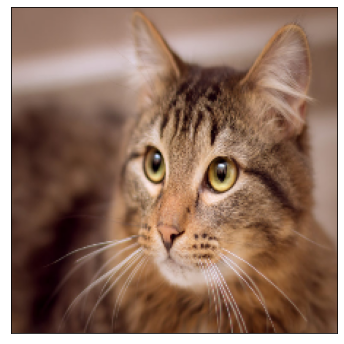

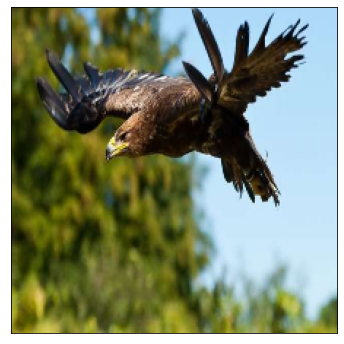

In [62]:
cat_img = read_img('cat.jpg')
eagle_img = read_img('eagle.jpg')

# **2. Import pretrained ResNet**

The ResNet50 network and its parameters (trained on Imagenet) are imported here. There is no need to include the last layer, since we only want to take a look at what happens in the convolutional base.

In [63]:
# import pretrained network 
resnet_50 = tf.keras.applications.ResNet50(include_top = False, weights = 'imagenet', input_shape = (224,224,3))
#resnet_50.summary()
print('Number of layers in Convolutional base', len(resnet_50.layers))

Number of layers in Convolutional base 175


# **3. Prepare images for ResNet, get layer activations, plot heatmaps**

In this section, the `preprocess_input` function from keras.applications.resnet50 is called to prepare images in such a way that ResNet can process them accurately. 
Then :
* the **get_activations** function gathers the activations for a specific image and a specified layer
* the **postprocess_activations** function averages them over all the filters, and converts them to a image of the original images's size
* the **apply_heatmap** function allows to plot these average activations over the original image, and to see which parts of the images have triggered filters in a specific layer


In [68]:
def preprocess(img):
  img = preprocess_input(img)
  # as the model is designed to get batches, we create a batch of 1 image
  img = tf.expand_dims(img,0)  # tf.expand_dims(tensor, axis) 
  return img                   


def get_activations(input_image, layer_idx):
  layer = resnet_50.layers[layer_idx]
  # create a simple model that returns the activations for a given layer
  model = tf.keras.models.Model(inputs = resnet_50.inputs, outputs = layer.output)   
  return model.predict(input_image)


def postprocess_activations(activations):
  # we want to visualize the average activation for each layer, not specific filters within each layer
  # average absolute activations within a layer
  activations = tf.abs(activations)
  output = tf.reduce_sum(activations, axis = -1)   # sum the activations of all the filters within a layer, at each specific location
  output = tf.squeeze(output).numpy()              # tf.squeeze() removes dimensions of size 1
  
  # resize and convert to image
  output = cv2.resize(output, (224,224))
  output = (output/np.max(output))*255
  return 255 - output.astype('uint8')


def apply_heatmap(weights, image) :
  # overlay original image with activation heatmaps 
  heatmap = cv2.applyColorMap(weights, cv2.COLORMAP_JET)
  heatmap = cv2.addWeighted(heatmap, 0.7, image, 0.3,0)   
  return heatmap

def plot_heatmaps(original_image, preprocessed_image, layer_list):
  
  # prepare the heatmaps 
  level_maps = None
  for i in layer_list :
    activations = get_activations(preprocessed_image,i)
    weights = postprocess_activations(activations)
    heatmap = apply_heatmap(weights, original_image)
    if level_maps is None:
      level_maps = heatmap
    else:
      level_maps = tf.concat([level_maps, heatmap], axis = 1)

  plt.figure(figsize=(24, 24))
  plt.axis('off')
  plt.imshow(level_maps)



def plot_the_heatmaps(original_img, early_layers = [3,4,5,6], middle_layers_1 = [49,50,51,52], middle_layers_2 = [100,101,102,103],  deep_layers = [150,151,152,153]): 

  preprocessed_image = preprocess(original_img)

  plot_heatmaps(original_img, preprocessed_image, early_layers)
  plot_heatmaps(original_img, preprocessed_image, middle_layers_1)
  plot_heatmaps(original_img, preprocessed_image, middle_layers_2)
  plot_heatmaps(original_img, preprocessed_image, deep_layers)

# **4. Try it on our images**

*Look at the readme file for comments*

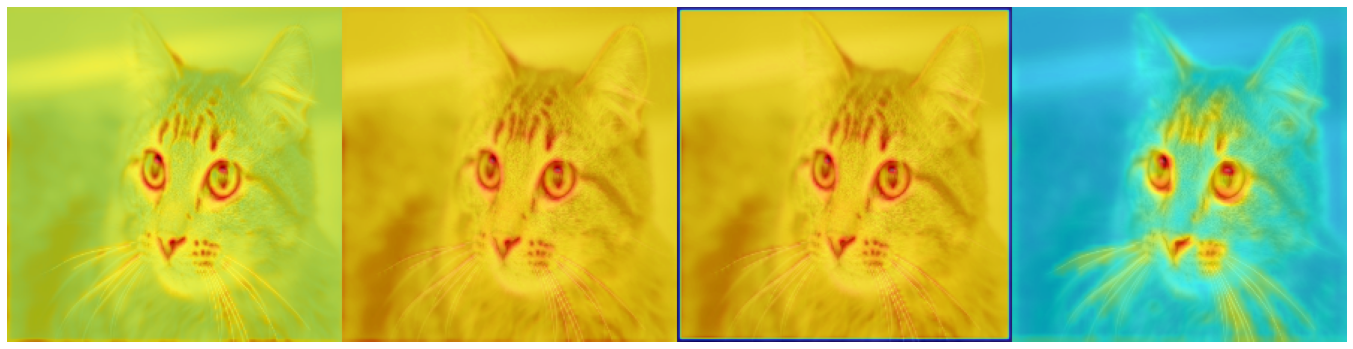

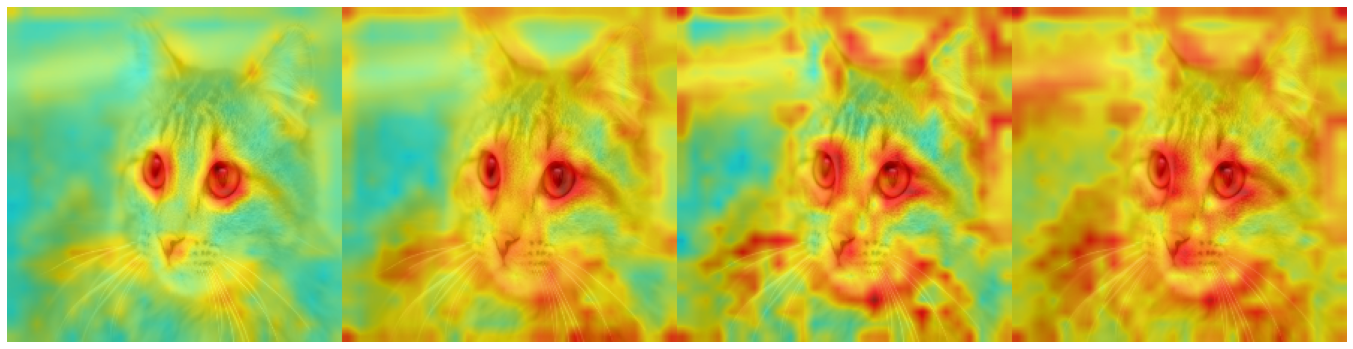

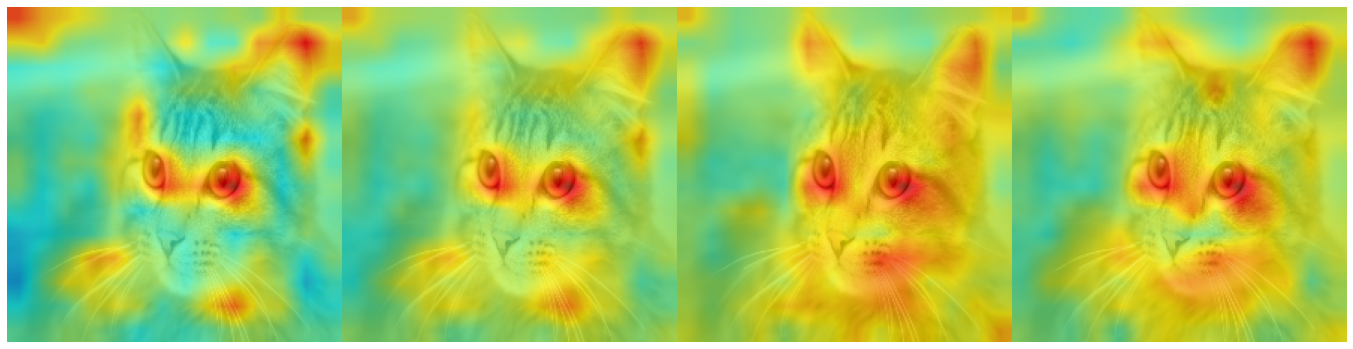

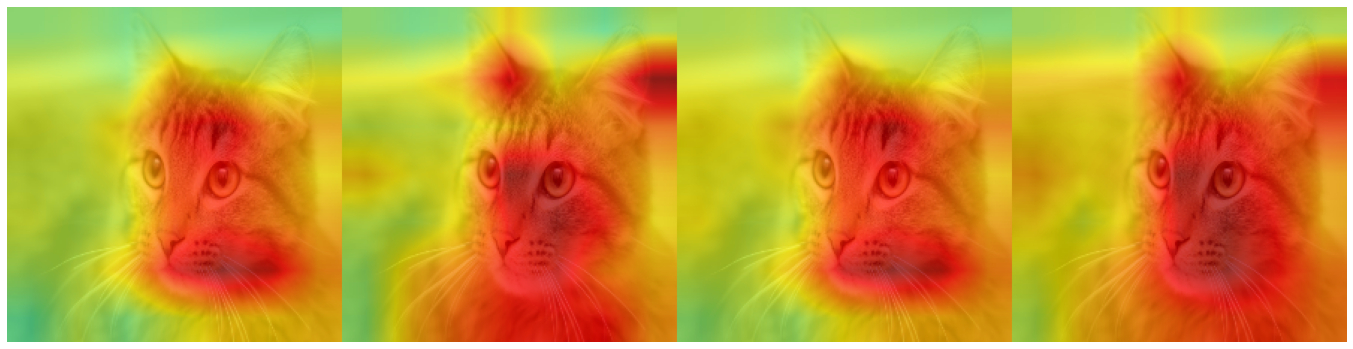

In [74]:
 plot_the_heatmaps(cat_img)

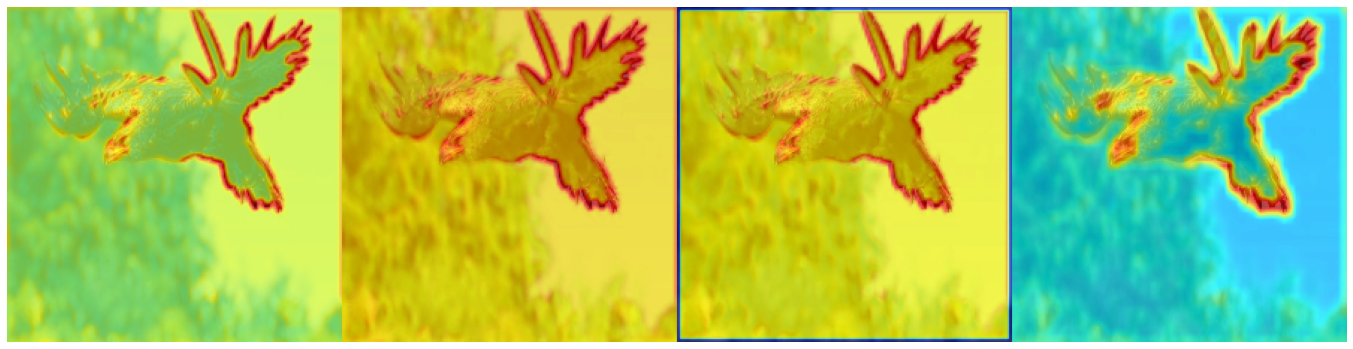

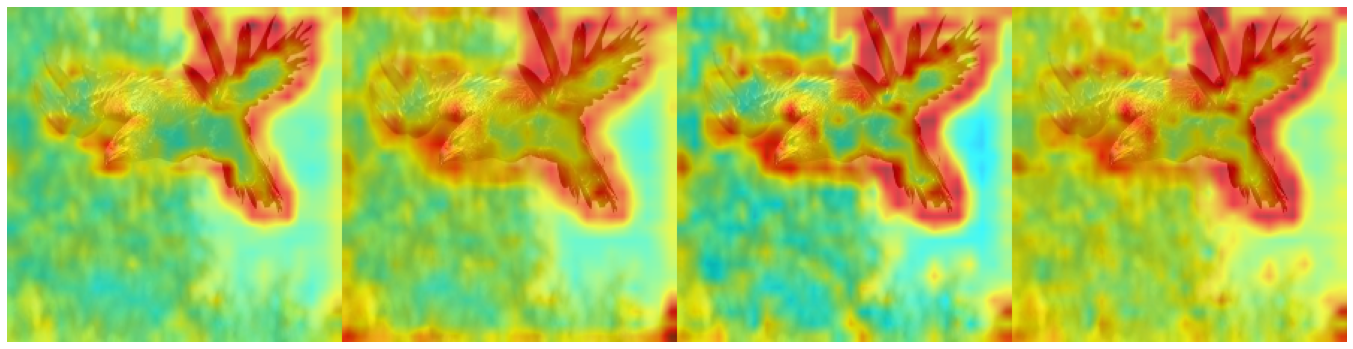

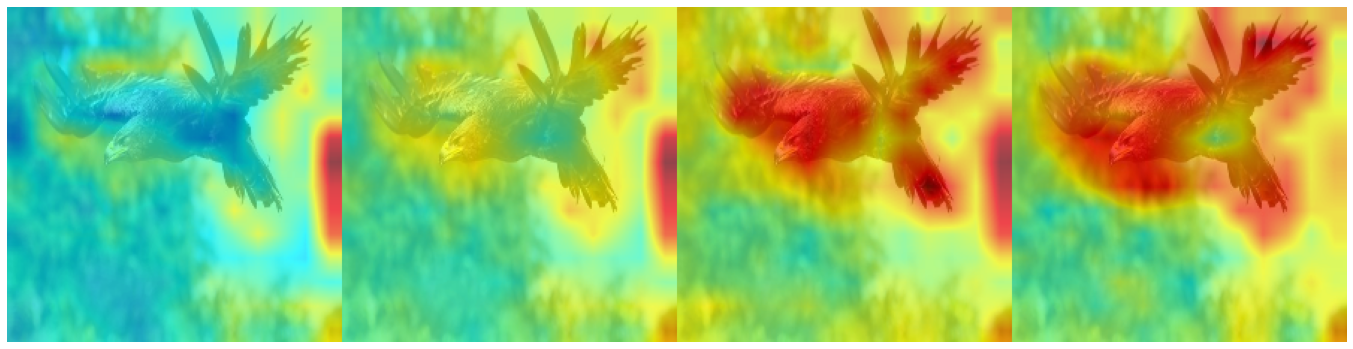

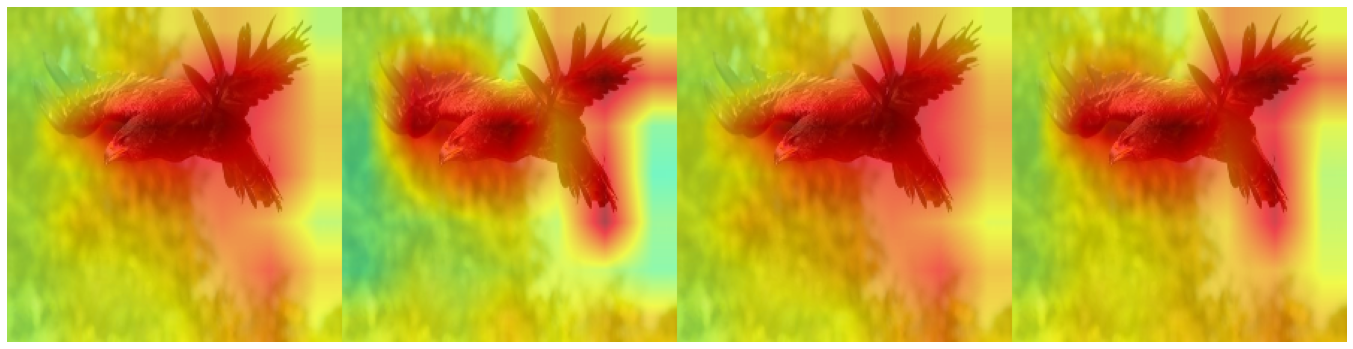

In [75]:
plot_the_heatmaps(eagle_img)